### Install and Import

In [3]:
pip install tensorflow==2.11.0 opencv-python mediapipe scikit-learn matplotlib


  Using cached mediapipe-0.10.11-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached sounddevice-0.4.6-py3-none-win_amd64.whl (199 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\avani\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [156]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt
import mediapipe as mp

### Drawing Keypoints on Video Feed

In [157]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [158]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [159]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [160]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [183]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened(): #always

    ret, frame = cap.read()

    image, results = mediapipe_detection(frame, holistic)

    draw_styled_landmarks(image, results)

    cv2.imshow('OpenCV Feed', image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

In [184]:
len(results.face_landmarks.landmark)

468

In [185]:
draw_landmarks(frame, results)

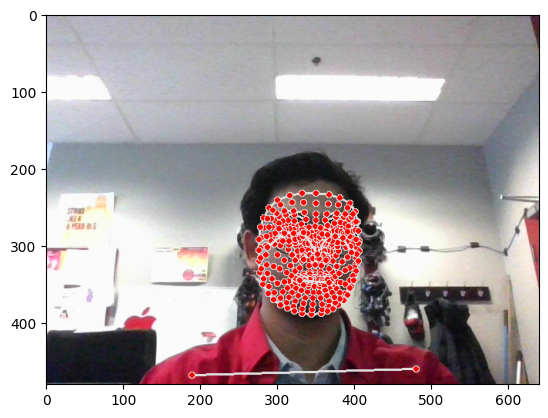

In [186]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extracting Keypoints

In [187]:
len(results.pose_landmarks.landmark)

33

In [188]:
len(results.face_landmarks.landmark)

468

In [189]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [190]:
len(results.right_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [191]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [192]:
extract_keypoints(results)[:5]

array([ 0.55071658,  0.64898962, -1.17177641,  0.99961525,  0.57185382])